# ***Modelos Ligeros***

## **Librerías y carga de datos**


In [1]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_dir = r"/content/drive/MyDrive/PDG/data/"
#root_dir = '/content/drive/MyDrive/aaa/'
#root_dir = "/content/drive/MyDrive/Proyecto-de-Grado-RAD-Alert/Oficial/Ahora-si-este-fue/data/"

In [4]:
file_original = root_dir + "base_df.xlsx"
file_aug_train = root_dir + "train_oversample_df.xlsx"
file_aug_val  = root_dir + "val_df.xlsx"
file_test = root_dir + "test_df.xlsx"

## **Preprocesamiento**

In [5]:
TEXT   = "texto"
LABEL  = "etiqueta"

In [6]:
tfidf = TfidfVectorizer(
    max_features=20_000,
    ngram_range=(1,2),
    min_df=3,
    sublinear_tf=True
)

In [7]:
prepro = ColumnTransformer(
    transformers=[("tfidf", tfidf, TEXT)],
    remainder="drop"
)

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## **Métricas**

In [9]:
scoring = {
    "precision": make_scorer(precision_score, zero_division=0),
    "recall"   : make_scorer(recall_score,    zero_division=0),
    "f1"       : make_scorer(f1_score,        zero_division=0)
}

## **Modelos**

In [10]:
models_grids = {
    "NaiveBayes": (
        MultinomialNB(),
        {"clf__alpha": [0.1, 0.5, 1.0]}
    ),
    "LogReg": (
        LogisticRegression(max_iter=1000, class_weight="balanced"),
        {"clf__C": [0.1, 1, 10]}
    ),
    "LinearSVM": (
        LinearSVC(class_weight="balanced"),
        {"clf__C": [0.1, 1, 10]}
    )
}

## **Grid**

In [11]:
def grid_search_models(X_tr, y_tr):
    best = {}
    for name, (clf, grid) in models_grids.items():
        pipe = Pipeline([("prep", prepro), ("clf", clf)])
        gs   = GridSearchCV(
            pipe, grid,
            scoring=scoring,
            refit="recall",
            cv=cv,
            n_jobs=-1, verbose=0
        )
        gs.fit(X_tr, y_tr)
        best[name] = gs.best_estimator_
        print(f"{name}: recall CV={gs.best_score_:.3f} | params={gs.best_params_}")
    return best

def evaluate_on_test(models, X_te, y_te, scenario):
    for name, model in models.items():
        y_pred = model.predict(X_te)
        print(f"\n=== {name} – {scenario} ===")
        print(classification_report(y_te, y_pred, digits=3))
        cm = confusion_matrix(y_te, y_pred)
        ConfusionMatrixDisplay(cm, display_labels=["No crítico","Crítico"]).plot(cmap="Blues")
        plt.title(f"CM – {name} ({scenario})")
        plt.show()

## **Dataset Original**


Grid-search (ORIGINAL)…
NaiveBayes: recall CV=0.837 | params={'clf__alpha': 0.1}
LogReg: recall CV=0.875 | params={'clf__C': 1}
LinearSVM: recall CV=0.879 | params={'clf__C': 0.1}

Evaluación en test (ORIGINAL)

=== NaiveBayes – Original ===
              precision    recall  f1-score   support

           0      0.950     0.897     0.923       535
           1      0.643     0.798     0.712       124

    accuracy                          0.879       659
   macro avg      0.797     0.848     0.818       659
weighted avg      0.893     0.879     0.883       659



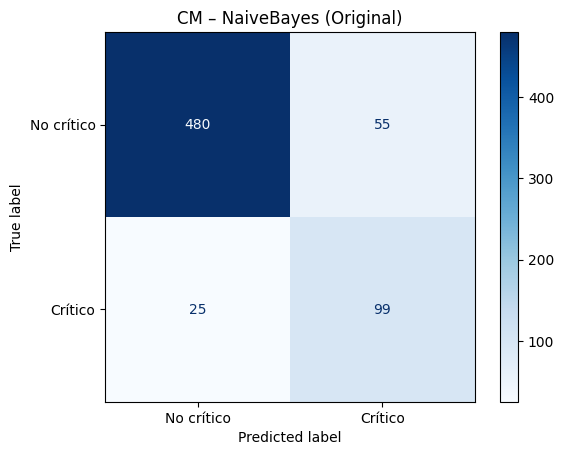


=== LogReg – Original ===
              precision    recall  f1-score   support

           0      0.974     0.908     0.940       535
           1      0.694     0.895     0.782       124

    accuracy                          0.906       659
   macro avg      0.834     0.902     0.861       659
weighted avg      0.921     0.906     0.910       659



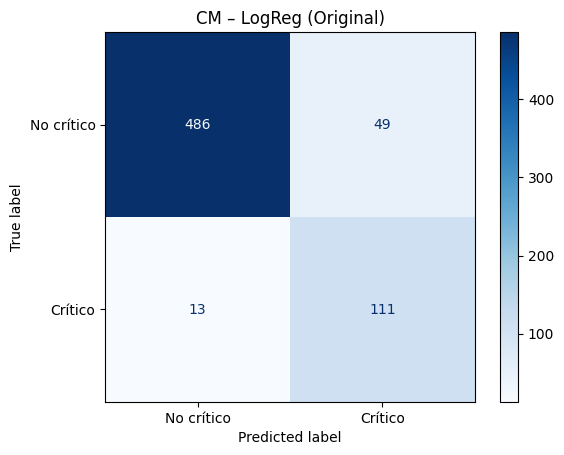


=== LinearSVM – Original ===
              precision    recall  f1-score   support

           0      0.974     0.912     0.942       535
           1      0.703     0.895     0.787       124

    accuracy                          0.909       659
   macro avg      0.838     0.904     0.865       659
weighted avg      0.923     0.909     0.913       659



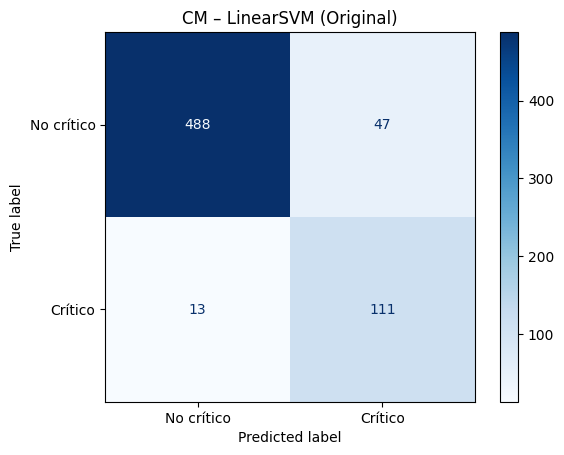


Evaluación en test_df (TERCERA VALIDACIÓN)

=== NaiveBayes – Test Final ===
              precision    recall  f1-score   support

           0      0.972     0.864     0.915        81
           1      0.607     0.895     0.723        19

    accuracy                          0.870       100
   macro avg      0.790     0.879     0.819       100
weighted avg      0.903     0.870     0.879       100



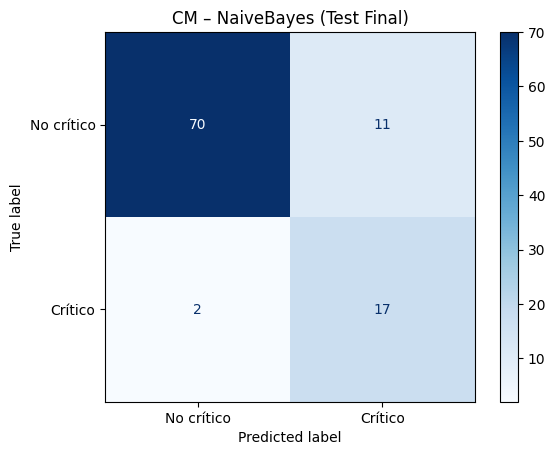


=== LogReg – Test Final ===
              precision    recall  f1-score   support

           0      0.987     0.914     0.949        81
           1      0.720     0.947     0.818        19

    accuracy                          0.920       100
   macro avg      0.853     0.930     0.883       100
weighted avg      0.936     0.920     0.924       100



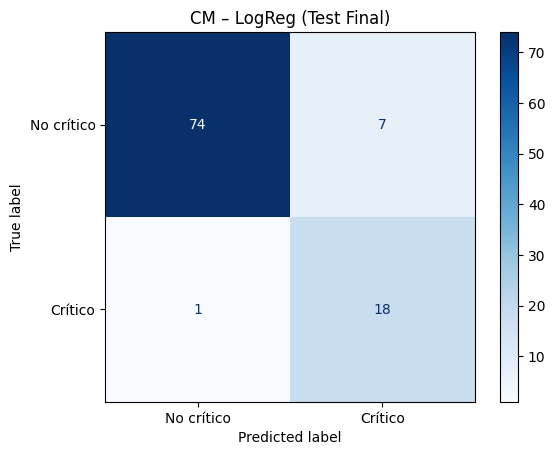


=== LinearSVM – Test Final ===
              precision    recall  f1-score   support

           0      1.000     0.938     0.968        81
           1      0.792     1.000     0.884        19

    accuracy                          0.950       100
   macro avg      0.896     0.969     0.926       100
weighted avg      0.960     0.950     0.952       100



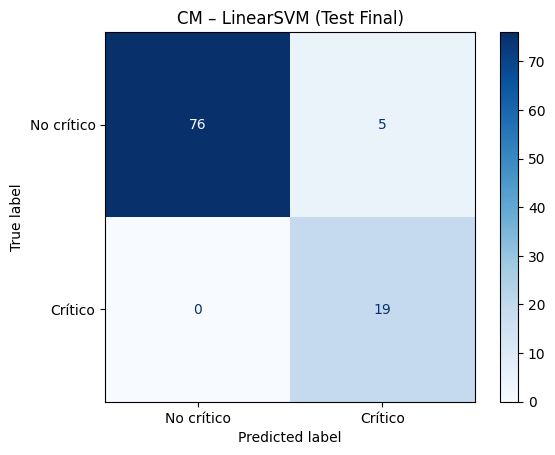

In [13]:
df_orig = pd.read_excel(file_original)
df_test = pd.read_excel(file_test)

Xo = df_orig[[TEXT]]
yo = df_orig[LABEL].values
Xo_tr, Xo_te, yo_tr, yo_te = train_test_split(
    Xo, yo, test_size=0.2, stratify=yo, random_state=42
)
Xt = df_test[[TEXT]]
yt = df_test[LABEL].values


print("\nGrid-search (ORIGINAL)…")
models_orig = grid_search_models(Xo_tr, yo_tr)

print("\nEvaluación en test (ORIGINAL)")
evaluate_on_test(models_orig, Xo_te, yo_te, "Original")

print("\nEvaluación en test_df (TERCERA VALIDACIÓN)")
evaluate_on_test(models_orig, Xt, yt, "Test Final")

| Modelo     | Validación | Accuracy | Precision | Recall | F1-score |
| ---------- | ---------- | -------- | --------- | ------ | -------- |
| NaiveBayes | Original   | 0.879    | 0.797     | 0.848  | 0.818    |
| NaiveBayes | Test Final | 0.870    | 0.790     | 0.879  | 0.819    |
| LogReg     | Original   | 0.906    | 0.834     | 0.902  | 0.861    |
| LogReg     | Test Final | 0.920    | 0.853     | 0.930  | 0.883    |
| LinearSVM  | Original   | 0.909    | 0.838     | 0.904  | 0.865    |
| LinearSVM  | Test Final | 0.950    | 0.896     | 0.969  | 0.926    |


### **Análisis de Resultados – Modelos Ligeros (Original y Test Final)**

1. **Comparación entre modelos:**

   * **LinearSVM** es el modelo con mejor desempeño general, alcanzando el mayor accuracy (0.950), recall (0.969) y F1-score (0.926) en la validación final. Esto indica que es el modelo más robusto y equilibrado tanto en la base original como en el test final.
   * **Logistic Regression (LogReg)** también muestra muy buen rendimiento, especialmente en la validación final (accuracy de 0.920 y recall de 0.930), lo que lo convierte en una alternativa fuerte si se prefiere un modelo interpretativo.
   * **Naive Bayes** es consistentemente el modelo con menor desempeño en comparación, especialmente en precisión y F1-score, aunque mantiene un recall competitivo, lo que lo hace útil en escenarios donde es más importante identificar casos positivos (sensibilidad) a costa de una mayor tasa de falsos positivos.

2. **Generalización y estabilidad:**

   * Todos los modelos mantienen un rendimiento similar entre la validación original y la prueba final, lo que refleja buena capacidad de **generalización** a datos no vistos.
   * El ligero aumento en los resultados de LogReg y LinearSVM en el test final sugiere que los datos de prueba pueden estar alineados en distribución o bien que los modelos no están sobreajustados.

3. **Interpretación de métricas:**

   * **Accuracy** y **recall** son altos en todos los casos (>0.87), lo que indica que los modelos son eficaces en identificar correctamente ambas clases.
   * El **F1-score** de LinearSVM en el test final (0.926) destaca como el más alto, lo que indica el mejor balance entre precisión y recall.
   * **Precision** es más baja en Naive Bayes, lo que sugiere más falsos positivos, mientras que LogReg y LinearSVM logran un mejor equilibrio.

4. **Conclusiones prácticas:**

   * **LinearSVM** es la mejor opción para la tarea si el objetivo es maximizar el desempeño global, especialmente en recall y F1.
   * **Logistic Regression** es adecuada si se prefiere interpretabilidad y solo una pequeña pérdida de desempeño.
   * **Naive Bayes** podría considerarse en casos donde se necesite alta velocidad de entrenamiento o para establecer una línea base sencilla, pero no para producción en este caso.



## **Datased Aumentado**

In [14]:
df_tr = pd.read_excel(file_aug_train)
df_te = pd.read_excel(file_aug_val)

In [15]:
df_tr

,texto,etiqueta
0,cardiopatia compleja. surcos y circunvolucione...,0
1,el paciente presenta un traumatismo craneoence...,1
2,cefalea surcos y circunvoluciones simetricos. ...,0
3,se sospecha de un accidente cerebrovascular - ...,1
4,"acv previo, trombocitopenia, anticoagulada con...",0
...,...,...
3378,desorientacion. prominencia de surcos y cisura...,0
3379,antecedente de tce: ahora confuso: a descartar...,0
3380,cefalea intensa en paciente anticoagulado. sur...,0
3381,cefalea. antecedente de hemorragia subaracnoid...,0


In [16]:
df_te

,texto,etiqueta
0,ea- hta- dm- enfermedad coronaria- somnolencia...,0
1,"seguimiento postquirurgico, drenaje coleccion ...",1
2,antecedente de trauma craneal e inestabilidad ...,0
3,posible sindrome de demencial. prominencia de ...,0
4,asimetria facial y craneana.sinofris. surcos y...,0
...,...,...
654,cefalea en estudio. surcos y circunvoluciones ...,0
655,cefalea en estudio. surcos y circunvoluciones ...,0
656,"paciente con hemorragia subaracnoidea, descart...",1
657,nr la atenuacion del parenquima es normal para...,0



 Grid-search (AUMENTADO)…
NaiveBayes: recall CV=0.945 | params={'clf__alpha': 0.1}
LogReg: recall CV=0.947 | params={'clf__C': 10}
LinearSVM: recall CV=0.953 | params={'clf__C': 10}

 Evaluación en test (AUMENTADO)

=== NaiveBayes – Aumentado ===
              precision    recall  f1-score   support

           0      0.928     0.957     0.942       535
           1      0.785     0.677     0.727       124

    accuracy                          0.904       659
   macro avg      0.856     0.817     0.835       659
weighted avg      0.901     0.904     0.902       659



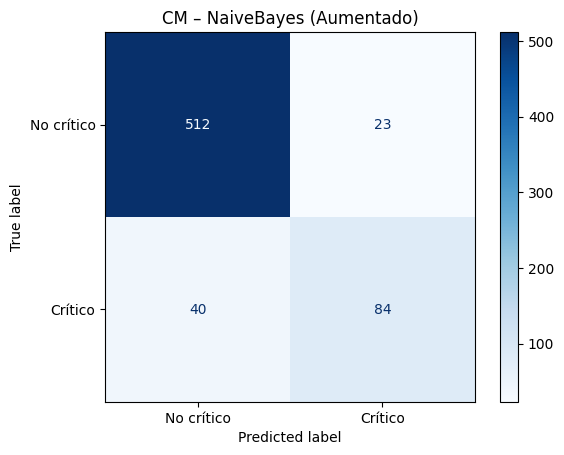


=== LogReg – Aumentado ===
              precision    recall  f1-score   support

           0      0.950     0.959     0.954       535
           1      0.815     0.782     0.798       124

    accuracy                          0.926       659
   macro avg      0.883     0.871     0.876       659
weighted avg      0.925     0.926     0.925       659



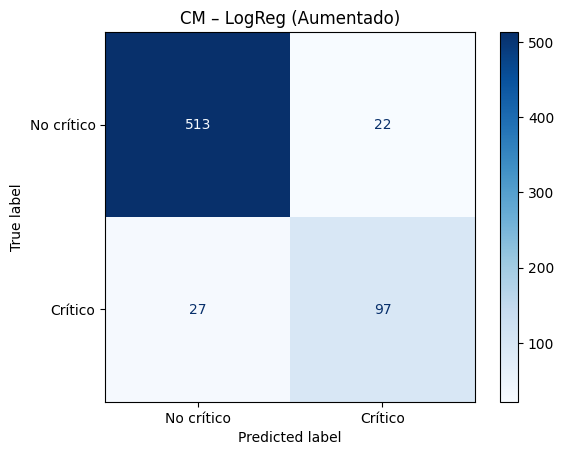


=== LinearSVM – Aumentado ===
              precision    recall  f1-score   support

           0      0.950     0.968     0.959       535
           1      0.851     0.782     0.815       124

    accuracy                          0.933       659
   macro avg      0.901     0.875     0.887       659
weighted avg      0.932     0.933     0.932       659



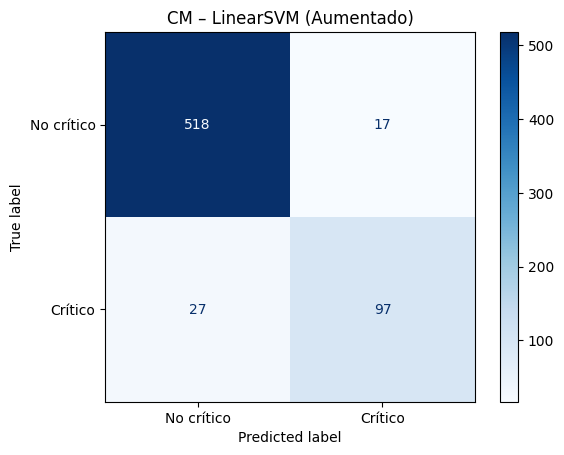


Evaluación en test_df (TERCERA VALIDACIÓN)

=== NaiveBayes – Test Final ===
              precision    recall  f1-score   support

           0      0.951     0.963     0.957        81
           1      0.833     0.789     0.811        19

    accuracy                          0.930       100
   macro avg      0.892     0.876     0.884       100
weighted avg      0.929     0.930     0.929       100



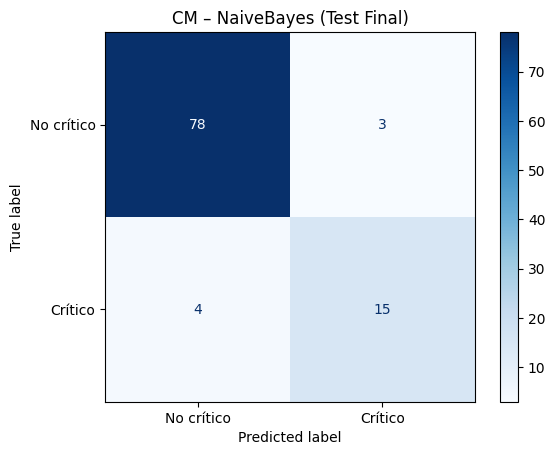


=== LogReg – Test Final ===
              precision    recall  f1-score   support

           0      0.941     0.988     0.964        81
           1      0.933     0.737     0.824        19

    accuracy                          0.940       100
   macro avg      0.937     0.862     0.894       100
weighted avg      0.940     0.940     0.937       100



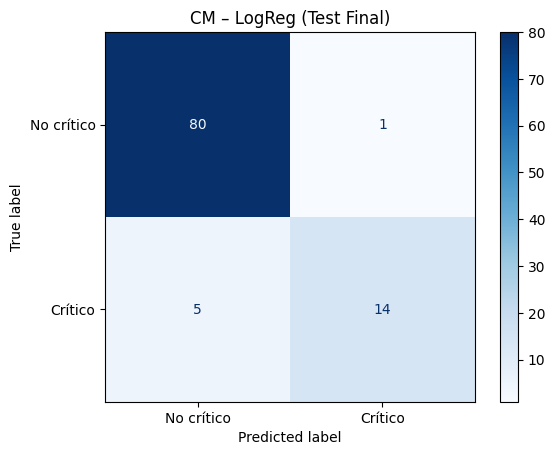


=== LinearSVM – Test Final ===
              precision    recall  f1-score   support

           0      0.929     0.975     0.952        81
           1      0.867     0.684     0.765        19

    accuracy                          0.920       100
   macro avg      0.898     0.830     0.858       100
weighted avg      0.917     0.920     0.916       100



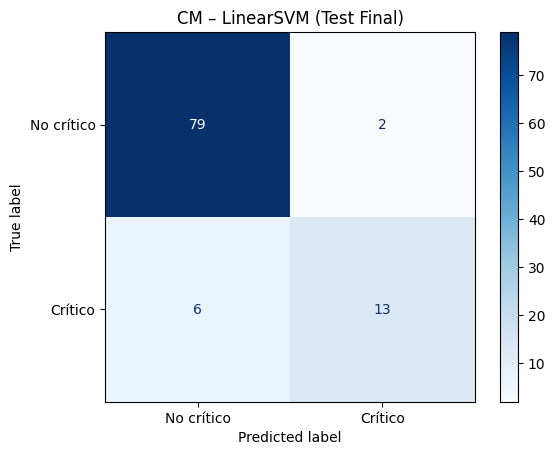

In [17]:
Xa_tr, ya_tr = df_tr, df_tr[LABEL].values
Xa_te, ya_te = df_te, df_te[LABEL].values


print("\n Grid-search (AUMENTADO)…")
models_aug = grid_search_models(Xa_tr, ya_tr)

print("\n Evaluación en test (AUMENTADO)")
evaluate_on_test(models_aug, Xa_te, ya_te, "Aumentado")

print("\nEvaluación en test_df (TERCERA VALIDACIÓN)")
evaluate_on_test(models_aug, Xt, yt, "Test Final")

| Modelo     | Validación | Accuracy | Precision | Recall | F1-score |
| ---------- | ---------- | -------- | --------- | ------ | -------- |
| NaiveBayes | Aumentado  | 0.904    | 0.856     | 0.817  | 0.835    |
| NaiveBayes | Test Final | 0.930    | 0.892     | 0.876  | 0.884    |
| LogReg     | Aumentado  | 0.926    | 0.883     | 0.871  | 0.876    |
| LogReg     | Test Final | 0.940    | 0.937     | 0.862  | 0.894    |
| LinearSVM  | Aumentado  | 0.933    | 0.901     | 0.875  | 0.887    |
| LinearSVM  | Test Final | 0.920    | 0.898     | 0.830  | 0.858    |


### **Análisis de Resultados – Modelos Ligeros (Set Aumentado y Test Final)**

1. **Comparación de modelos:**

   * **Logistic Regression (LogReg)** es el modelo con mayor **accuracy** (0.940), **precision** (0.937) y **F1-score** (0.894) en el test final, lo que lo posiciona como la mejor opción general tras el aumento de datos.
   * **LinearSVM** destaca en la validación con datos aumentados, pero su desempeño en el test final baja ligeramente en recall y F1-score, lo que sugiere cierta sobreajuste al set aumentado o sensibilidad a la distribución de los datos.
   * **Naive Bayes** muestra una mejora notable en la transición del set aumentado al test final, especialmente en precisión y F1-score, superando sus propios resultados originales.

2. **Impacto del aumento de datos:**

   * Todos los modelos mejoran sus resultados respecto al set original, especialmente en **precisión** y **F1-score** sobre el test final, lo que indica que la estrategia de aumento de datos ayudó a los modelos a **generalizar mejor**.
   * En particular, Naive Bayes logra una diferencia positiva significativa entre validación y test final (F1: 0.835 → 0.884).

3. **Estabilidad y generalización:**

   * **LogReg** es el modelo más **estable y robusto**, mostrando mejoras consistentes entre ambas validaciones y manteniendo altos valores en todas las métricas clave.
   * **LinearSVM** pierde desempeño en el test final, aunque sigue siendo competitivo y muestra que el aumento de datos es útil pero no suficiente para evitar posibles variaciones en datos no vistos.

4. **Interpretación de métricas:**

   * **Precision** y **F1-score** alcanzan valores muy altos (>0.89) en los modelos LogReg y Naive Bayes en el test final, mientras que LinearSVM se mantiene por encima de 0.85, lo que sugiere que todos los modelos gestionan bien el balance entre falsos positivos y falsos negativos.
   * **Recall** es más alto en Naive Bayes y LogReg en el test final, favoreciendo escenarios donde la detección de positivos es crítica.

5. **Conclusiones prácticas:**

   * **Logistic Regression** es el mejor modelo tras el aumento de datos, ideal para aplicaciones clínicas donde la generalización y la precisión son críticas.
   * **Naive Bayes** mejora considerablemente y puede considerarse como una opción ligera y eficaz tras el aumento.
   * **LinearSVM** sigue siendo competitivo, pero su desempeño en el test final sugiere revisar posibles ajustes o combinarlo con otras estrategias de regularización.